# AllLife Bank Customer Segmentation
## By: Swaraj Tripathy

The goal of this project is to identify different types of customers based on their spending patterns and past bank interactions. Identifying different customer groups will allow the bank to create personalized campaigns to gain new customers, as well as move customers from one group to another with more favorable spending patterns for the bank. To accomplish this task, I will be using K-means and hierarchical clustering techniques to generate a customer profile for the bank.

This analysis aims to answer the following questions: How many general types of customers are their at the bank? What factors distinguish each type of customer? For each customer type, how could the bank target their ads to gain new customers? What is the most favorable customer type and how can existing customers be influenced to adjust their spending habits to reach this group?

In [1]:
# import relevant libraries

# for reading and manipulating data
import pandas as pd
import numpy as np

# for visualizing data
import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns

# to apply clustering techniques
from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# to standardize the data
from scipy.stats import zscore

# to help visualize dendograms and evaluate clustering methods
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist, cdist
from sklearn.metrics import silhouette_score

# to apply principal component analysis
from sklearn.decomposition import PCA

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Exploratory Data Analysis

In [2]:
# load in the dataset
raw_data = pd.read_excel("Credit+Card+Customer+Data.xlsx", sheet_name = "Sheet1")

# make a copy of the data to be manipulated
data = raw_data.copy()
data.head(20)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


In [3]:
# shape of the dataset
data.shape

(660, 7)

In [4]:
# statistical summary of numerical columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


The average credit limit column seems to be skewed to the right as the mean is much larger than the median. The range of values is also very large so there may be some outliers. Since there is a wide variance of credit limits in the real world as there is a large disparity in wealth, we will likely keep these outliers untreated. All other columns seem to have reasonable ranges, and little to no skew.

In [5]:
# null counts and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


None of the variables have null values and all are numerical columns, which is good.

In [6]:
# check for duplicate rows
data.duplicated().sum()

0

No duplicate rows!

In [7]:
# check for missing values just to be sure
data.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

No missing values either!

In [8]:
# drop the Sl_No column and Customer key from the data as it doesn't add any information to our analysis
data = data.drop("Sl_No", axis = 1)
data = data.drop("Customer Key", axis = 1)

In [9]:
# we also only want columns that will be used in clustering in our scaled dataset
# we scale the data using the zscore
data_scaled = data.apply(zscore)
data_scaled.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739
5,-0.387644,-0.787585,-1.473731,-0.547490,1.542593
6,1.740187,0.135694,-1.473731,2.861408,-0.553005
7,-0.520633,-0.787585,-1.473731,-0.547490,-0.902271
8,-0.786612,-1.249225,-1.473731,-0.206600,-0.553005
9,-0.839808,-0.325946,-1.473731,-0.547490,1.193326


## Univariate Analysis

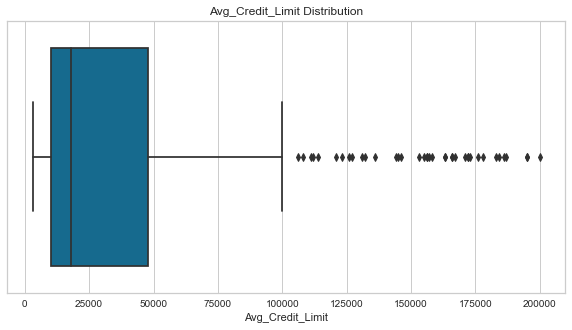

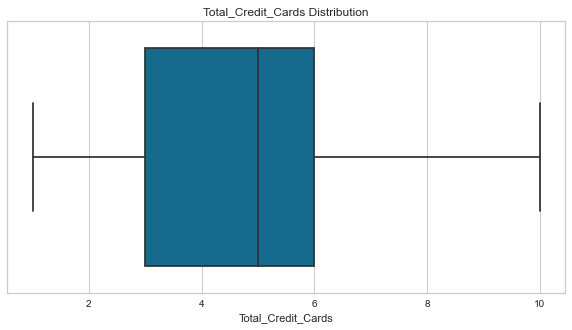

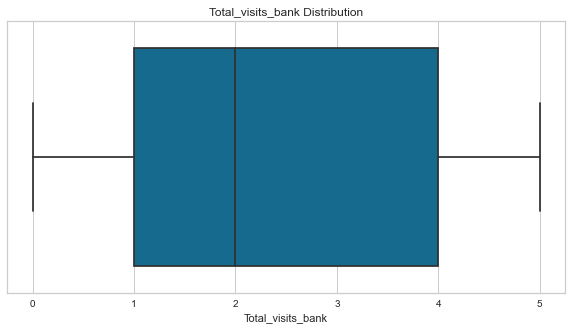

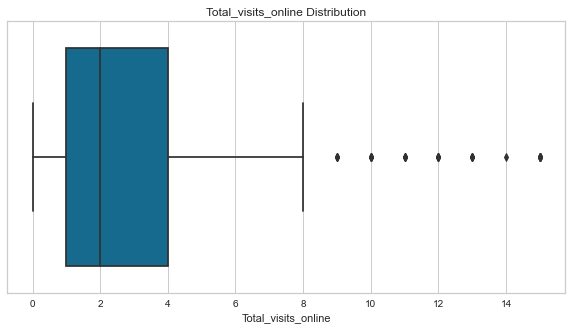

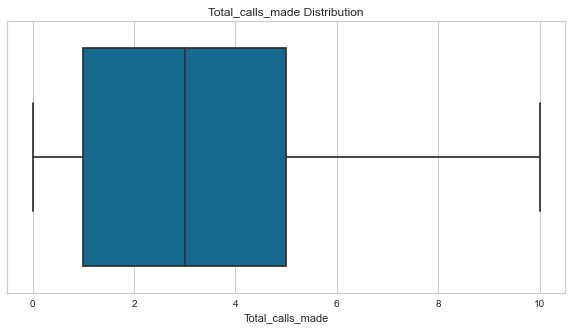

In [10]:
# boxplots for each variable
for feature in data.columns:
    plt.figure(figsize = (10,5))
    plt.title(feature + " Distribution")
    sns.boxplot(data = data, x = feature)
    plt.show()

Like I mentioned before, the average credit limit is skewed to the right, but the outliers are reasonable because of wealth disparity, so we are going to leave them intreated. Also, 15 online visits is not too unreasonable. All other variables seem relatively unskewed.

- The median avarage credit limit is 18000 with an IQR of 10000 to 48000
- 50% of customers had 3-6 credit cards total
- Customers made between 0-5 visits to the bank per year, with 50% of customers visiting between 1-4 times
- Almost all customers made less than 8 online visits per year
- 50% of customers called the bank between 1-5 times per year

## Bivariate Analysis

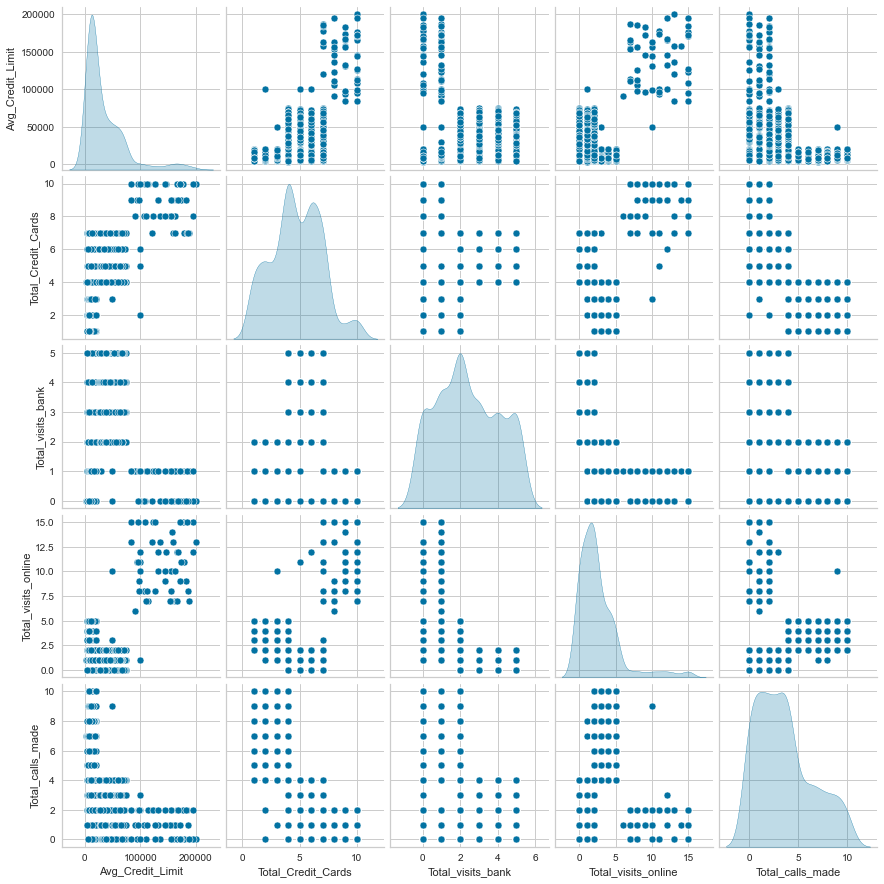

In [11]:
# pairplot of original data
sns.pairplot(data = data, diag_kind = "kde");

- There seems to be a positive relationship between average credit limit and total credit cards
- We also see a positive relationship with total credit cards and total visits online
- There is a positive relationship between average credit limit and total visits online as well
- Just by looking, we can see two potential clusters in our data with low credit limit, low credit cards, and low visits online vs high values in those categories

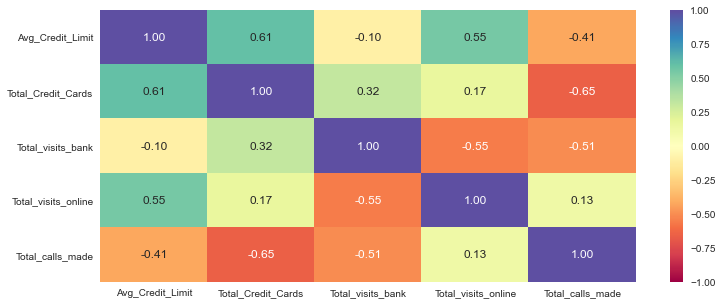

In [12]:
plt.figure(figsize = (12, 5))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral");

- We see the same positive relationships from the scatterplots
- We also see a positive correlation between total bank visits and total credit cards
- There is a negative relationship between total calls made with average credit limit, total credit cards, and total bank visits

## K-Means Clustering

Text(0.5, 1.0, 'Selecting K with the Elbow Method')

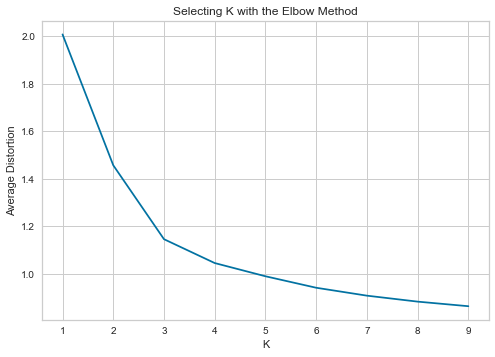

In [13]:
# finding the optimal number of clusters
# we are going to try clustering with 1-10 clusters
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters = k, random_state = 1)
    model.fit(data_scaled)
    prediction = model.predict(data_scaled)
    meanDistortions.append(sum(np.min(cdist(data_scaled, model.cluster_centers_, 'euclidean'), axis = 1)) / data_scaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Average Distortion')
plt.title('Selecting K with the Elbow Method')

We want to select a k (the number of clusters) around the elbow of the graph above. This is not an exact measure of the optimum number of clusters, so although the "best" elbow is at k = 3, we want to test k = 2 and k = 4 as well. The results in out EDA seem to show 2 clusters as a possibility as well, so we want to make sure to check that.

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.255906765297388
For n_clusters = 7, silhouette score is 0.24798644656011146
For n_clusters = 8, silhouette score is 0.2414240144760896
For n_clusters = 9, silhouette score is 0.2184645050755029


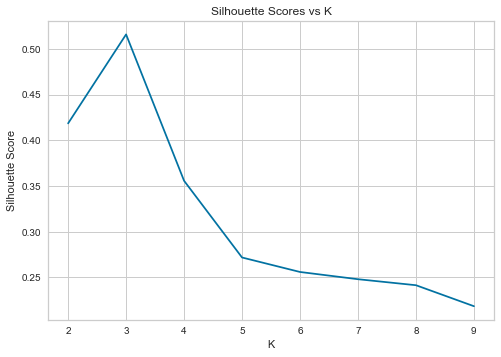

In [14]:
# checking the silhouette scores for different values of k
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    model = KMeans(n_clusters = n_clusters, random_state = 1)  # Initializing KMeans algorithm
    prediction = model.fit_predict((data_scaled))  # Predicting on the data
    score = silhouette_score(data_scaled, prediction)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.title("Silhouette Scores vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.plot(cluster_list, sil_score);

Based on the silhouette scores, it seems that k = 3 is a good option, but k = 2 and k = 4 are still usable options. We will use the silhouette visualizer to confirm which values of k are really optimal. We are looking for values of k such that:

  - There should be no negative silhouette coefficent value
  - All the clusters should cross the avg silhouette score
  - All the clusters should have the different variations (width)
  - All the clusters should have different silhouette score

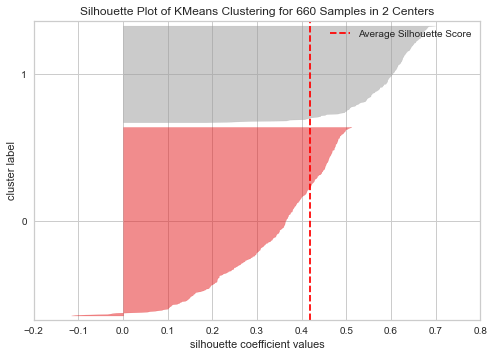

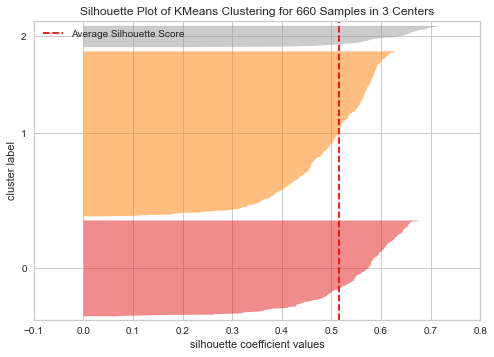

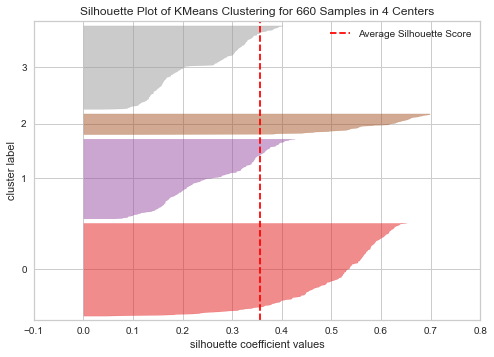

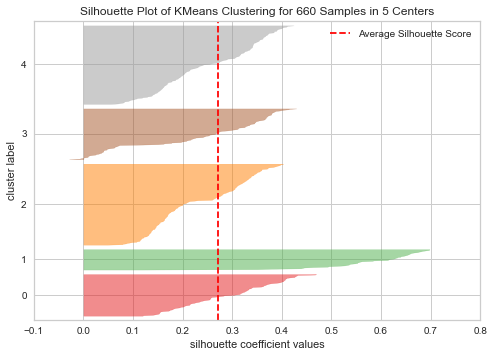

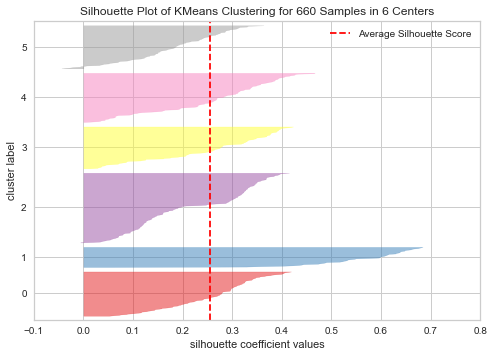

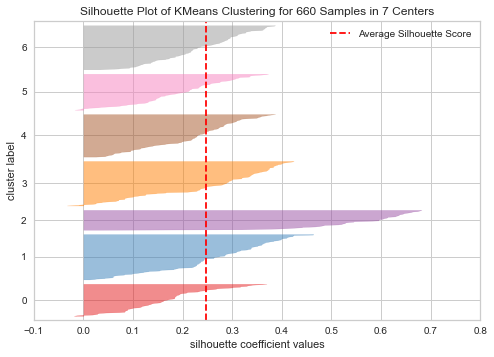

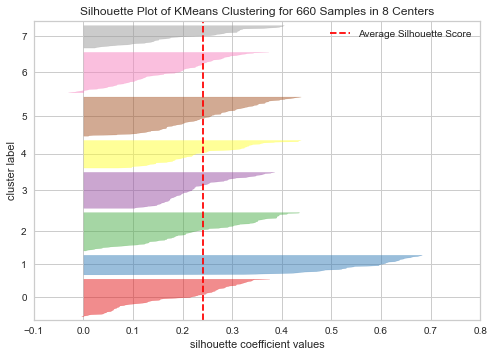

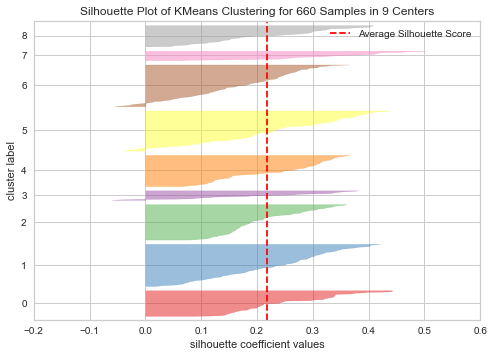

In [15]:
# finding the optimal number of clusters with silhouette coefficients
for k in cluster_list:
    visualizer = SilhouetteVisualizer(KMeans(k, random_state = 1))
    visualizer.fit(data_scaled)
    visualizer.show();

Using the silhouette visualizer, we can see that values of k that are greater than 5 and k = 2 has negative silhouette scores, so we won't use those. We will choose between k = 3 and k = 4, but for k = 4, cluster label 1 and 3 are very similar in width and silhouette score, so 3 is our best choice. This supports our elbow method analysis as we also chose k = 3 from there.

In [16]:
# let's fit the k means clustering model with k = 3 and investigate the different clusters
kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=1)

In [17]:
# adding kmeans cluster labels to the original dataframe
data["K_means_segments"] = kmeans.labels_

In [18]:
# group by each cluster to get profiles using mean values within each cluster
cluster_profile = data.groupby("K_means_segments").mean()

In [19]:
# add the observation counts to the profile
cluster_profile["Observation_counts"] = (
    data.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [20]:
# let's display cluster profiles
# blue denotes minimums, green denotes maximums
cluster_profile.style.highlight_max(color = "lightgreen", axis = 0).highlight_min(color = "lightblue", axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Observation_counts
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


From our cluster profile, we can get an idea of each customer type in this data. Customers in cluster 0 tend to have the lowest credit limits and less credit cards, but the most calls made to the bank. Customers in cluster 1 typically have much higher in person bank visits, and much less activity online, if any. Cluster 2 are counterparts to those in cluster 0, with high credit limits, many credit cards, much more online visits, but less calls made to the bank and less visits to the bank physically.

## Hierarchical Clustering

0.7391220243806552


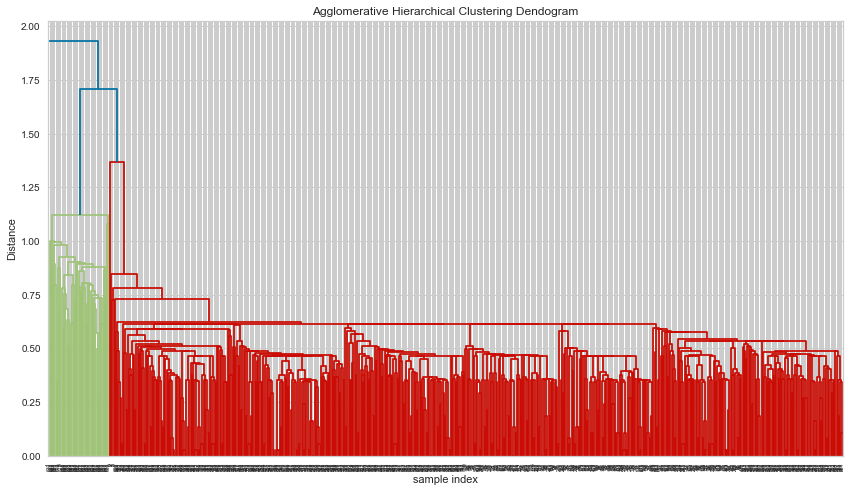

In [21]:
# we are going to try hierarchical clustering using a variety of linkage methods
# to evaluate the clustering, we look at the cophenetic correlation
# we will use euclidean distance measures for all models for consistency

# hierarchical clustering using single linkage
Z = linkage(data_scaled, metric = 'euclidean', method = 'single')
c, coph_dists = cophenet(Z , pdist(data_scaled))

# cophenetic correlation (closer to 1 means better clustering)
print(c)

plt.figure(figsize = (12, 7))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation = 90., color_threshold = 1.5)
plt.tight_layout()

0.8599730607972423


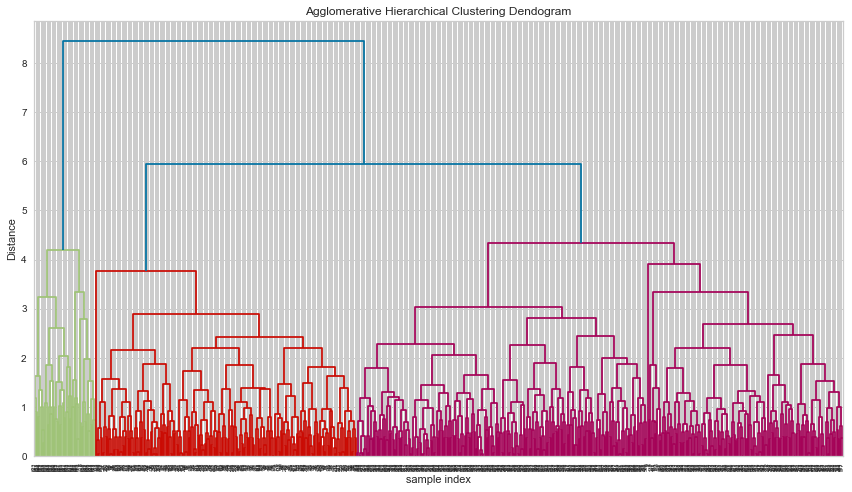

In [22]:
# hierarchical clustering using complete linkage
Z = linkage(data_scaled, metric = 'euclidean', method = 'complete')
c, coph_dists = cophenet(Z , pdist(data_scaled))

# cophenetic correlation (closer to 1 means better clustering)
print(c)

plt.figure(figsize = (12, 7))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation = 90., color_threshold = 5,  )
plt.tight_layout()

0.7415156284827493


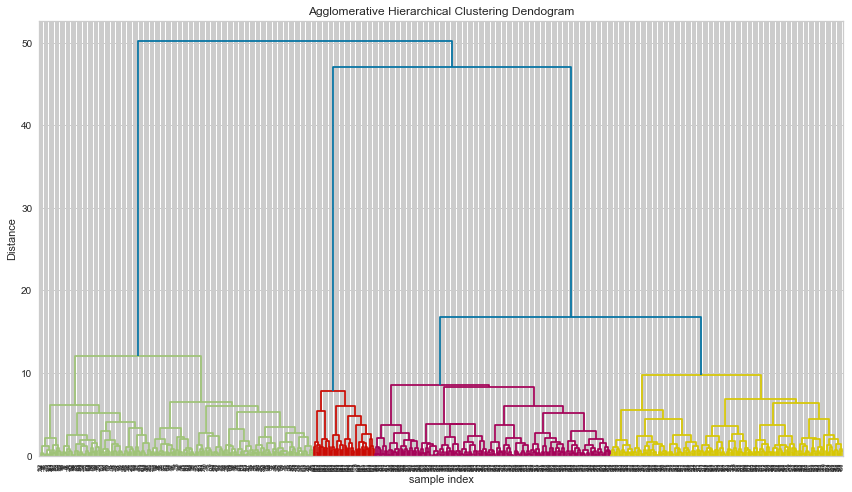

In [23]:
# hierarchical clustering using ward linkage
Z = linkage(data_scaled, metric = 'euclidean', method = 'ward')
c, coph_dists = cophenet(Z , pdist(data_scaled))

# cophenetic correlation (closer to 1 means better clustering)
print(c)

plt.figure(figsize = (12, 7))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation = 90., color_threshold = 15)
plt.tight_layout()

0.8939385846326323


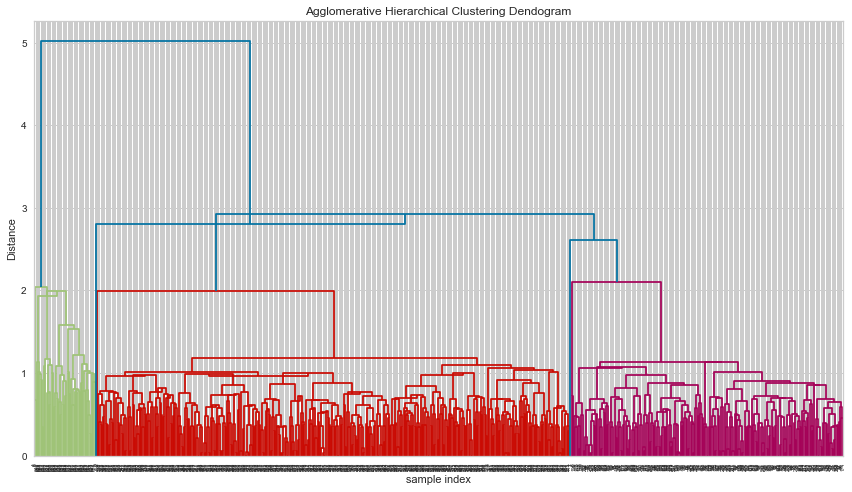

In [24]:
# hierarchical clustering using centroid linkage
Z = linkage(data_scaled, metric = 'euclidean', method = 'centroid')
c, coph_dists = cophenet(Z , pdist(data_scaled))

# cophenetic correlation (closer to 1 means better clustering)
print(c)

plt.figure(figsize = (12, 7))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation = 90., color_threshold = 2.5)
plt.tight_layout()

Hierarchical clustering with centroid linkage provided the largest cophenetic correlation, but complete linkage was pretty high as well. Looking at the dendograms for these hierarchical clustering models, we see that the optimum number of clusters seems to be 3 clusters in both cases, which is consistent with our k-means clustering. We can now fit the centroid linkage model and compare the customer profile to the k-means profile.

In [25]:
# fit the hierarchical clustering model with centroid linkage to develop customer profiles
hclust = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean',  linkage = 'average')
hclust.fit(data_scaled)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [26]:
# add the model labels to the data
data['hclust_labels_centroid'] = hclust.labels_
data.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,hclust_labels_centroid
0,100000,2,1,1,0,1,0
1,50000,3,0,10,9,0,2
2,50000,7,1,3,4,1,0
3,30000,5,1,1,4,1,0
4,100000,6,0,12,3,2,1
5,20000,3,0,1,8,0,2
6,100000,5,0,11,2,2,1
7,15000,3,0,1,1,0,2
8,5000,2,0,2,2,0,2
9,3000,4,0,1,7,0,2


In [27]:
# create our customer profile for hierarchical clustering
# group by each cluster to get profiles using mean values within each cluster
cluster_profile = data.groupby("hclust_labels_centroid").mean()

# add the observation counts to the profile
cluster_profile["Observation_counts"] = (
    data.groupby("hclust_labels_centroid")["Avg_Credit_Limit"].count().values
)

# let's display cluster profiles
# blue denotes minimums, green denotes maximums
cluster_profile.style.highlight_max(color = "lightgreen", axis = 0).highlight_min(color = "lightblue", axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,Observation_counts
hclust_labels_centroid,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.997416,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,0.000000,223


We see that our hierarchical clustering results gave us the same clusters as the k-means approach. There is just one observation that is clustered differently, and the average values are very similar to the k-means customer profile. Again we have one group with many in person bank visits with low online presence, one group with high credit limits, many credit cards, many online bank visits, with low in person visits and low calls made, and the counterpart customer group to the previous group with low credit limits and less credit cards.

Overall, both clustering methods provided almost identical results. The k-means approach took more preparation and analysis to determine the optimum value for k before fitting the model, but we ended up with the same results. However, when building the dendogram for the hierarchical clustering model, it took more time to determine the optimum number of clusters as the method was less exact; we just picked the best value based on the fit of the dendogram just by looking without much calculation like the elbow method.

## Recommendations & Insights

- From our clustering results, we found three distinct customer types in this dataset
    - Face-to-Face: This group of customers likes to physically visit the bank, but doesn't tend to use online banking tools. Although we don't have demographic data, it is possible that this group tend to be on the older side, who may not be up to speed with the newest technology of online banking. They may feel more comfortable talking directly to a human when handling their finances. This group is also in the middle in terms of wealth and number of credit cards, which could be due to an older population who has worked a full career to have some spending flexibility.
    - New Wealth: The smallest customer segment is characterized by very high credit limits, implying large amounts of wealth, and many credit cards with heavy usage of online banking tools. This group also has low in person visits and low phone calls to the bank, which is typically a characteristic of younger populations, who rely more on technology. However, this group likely consists of business owners due to the amount of wealth needed to have an average credit limit of 14000, and the large amount of online banking could be to save time. This group also uses many credit cards, which could be due to diversified wealth in businesses and taking advantage of the many perks associated with different credit cards like travel perks or cash back on gas.
    - Younger: This group is characterized by low credit limits, low amounts of credit cards, high numbers of phone calls, and a decent online presence. The low credit limit implies customers who are not as wealthy, which often includes younger customers. Younger, and newer customers of the bank likley would not be able to maintain many credit cards, but would still be tech-savy enough to take advantage of online banking. Making many phone calls to the bank could be a good way to get guidance from the bank on how to manage their finances in different accounts, such as checking, savings, and retirement accounts.
- Recommendations to increase the customer base for each segment:    
    - To increase customers in the Younger customer group, the bank could offer credit cards with no fees, generous payment cycles, and low credit limits to provide a low risk environment for new bank customers to start banking.
    - To increase customers in the New Wealth customer group the bank could offer ludicrous perks for wealthy customers. These customers clearly live lavish lifestyles to have credit limits that high, and are not afraid to have many different cards, so offering specific perks with each card tailored to wealthy people, such as cash back on boating supplies or fuel, could increase this customer base.
    - To increase customers in the Face-to-Face group, the bank could collect demographic information on potential customers and use targeted ads that give the older population the impression that the bank is a friendly, safe enviroment that is welcoming to people who like to do their finances old school with in person interactions. They could also downplay the importance of online banking to give these customers the feeling that they are not falling behind, or missing out with not being able to keep up with technology.